In [55]:
# /mnt/c/Users/Student/Desktop/Project$ code Alz_Classification/


import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import os 
import random



In [2]:


dataset = tf.keras.utils.image_dataset_from_directory(  
    "Alz_Datasets/Alz2/Axial/",
    shuffle = True,
    image_size = (256,170)
)


Found 5154 files belonging to 3 classes.


In [3]:
# parameters
batch_size = 16 # Hyperparamter 
image_height = 256
image_width = 170


In [36]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "training", 
    seed = 42, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 4124 files for training.


In [37]:

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "validation",
    seed = 42, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [39]:

class_names = train_dataset.class_names # Identification of class names
print(class_names) 

['AD', 'CI', 'CN']


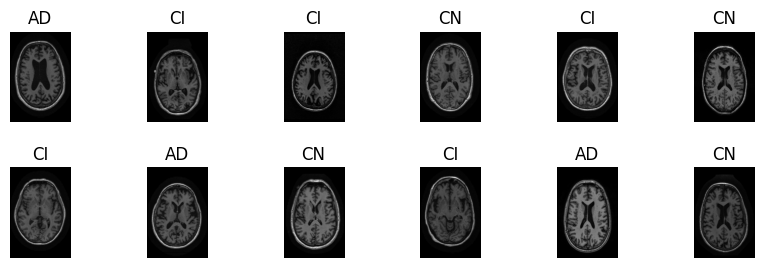

In [40]:
# Plots random 12 brain scans from dataset; just for something viusal
plt.figure(figsize=(10, 10)) # Creates a 10x10 size for the plot
for images, labels in train_dataset.take(1): # The loops the dataset and extracts batches of images with their corresponding labels
    for i in range(12): # Loops 12 times for 12 images
        ax = plt.subplot(6, 6, i + 1) # 6 rows 6 colums and selects current plot loctaion
        plt.imshow(images[i].numpy().astype("uint8")) # Image by converting it to numpy array and specifying its data type as integer unit8
        plt.title(class_names[labels[i]]) # Plots labels 
        plt.axis("off") # Removes Axis

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Spaces images width and height from eachother

plt.show() # displays the plot


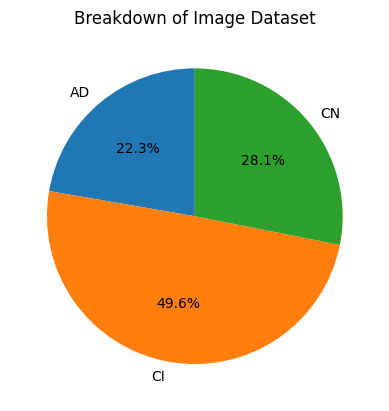

In [41]:

class_counts = [0] * len(class_names) #

for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[label] += 1


plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90) 
#Class Counts:data,labels:Class Names,autopct='%1.1f%%':Format of the percentage display,startangle=90 specifies the angle at which the first slice starts

plt.title('Breakdown of Image Dataset') # Plot Title


plt.show() # Displays the plot

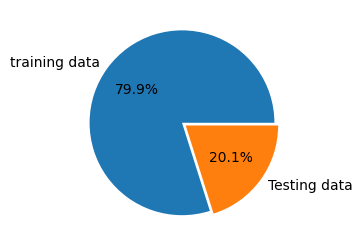

In [42]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(train_dataset), len(validation_dataset)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [43]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 256, 170, 3)
(16,)


In [44]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9943484


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(8, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build(input_shape=(None, image_height, image_width, 3))

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 170, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 170, 8)       224       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 128, 85, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 85, 16)       1168      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 42, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 42, 32)       

In [47]:
hist = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs= 3
)


Epoch 1/3


258/258 [==============================] - 12s 43ms/step - loss: 0.9035 - accuracy: 0.5744 - val_loss: 0.6741 - val_accuracy: 0.7369
Epoch 2/3
258/258 [==============================] - 9s 35ms/step - loss: 0.5279 - accuracy: 0.8000 - val_loss: 0.3595 - val_accuracy: 0.8835
Epoch 3/3
258/258 [==============================] - 8s 32ms/step - loss: 0.2414 - accuracy: 0.9256 - val_loss: 0.1701 - val_accuracy: 0.9641


In [14]:
model.save("model.keras")

In [48]:
model.evaluate(train_dataset)

258/258 [==============================] - 3s 10ms/step - loss: 0.1390 - accuracy: 0.9745


[0.13896431028842926, 0.9745392799377441]

In [49]:
model.evaluate(validation_dataset)

 1/65 [..............................] - ETA: 1s - loss: 0.2255 - accuracy: 0.8750

65/65 [==============================] - 1s 11ms/step - loss: 0.1701 - accuracy: 0.9641


[0.17009423673152924, 0.9640776515007019]

In [56]:
# def predictAndPlot(model, paths, labels, n_samples=100):
#     plt.figure(figsize=(10, 10))
#     for i in range(min(n_samples, len(paths))):
#         index = random.randint(0, len(paths)-1)
#         image_path = paths[index]
#         true_label = labels[index]
        
#         image = load_img(image_path, target_size=(imageSize, imageSize))
#         image_array = np.array([augmentImages(image)])
#         plt.subplots_adjust(hspace=0.5)

#         prediction_probabilities = model.predict(image_array)[0];
#         predicted_label_index = np.argmax(prediction_probabilities);
#         predicted_label = uniqueLables[predicted_label_index];
#         certainty = prediction_probabilities[predicted_label_index] * 100;
#         correct = true_label == predicted_label;
        
#         plt.subplot(5, 5, i+1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)


# predictAndPlot(model, testPaths, testLables, n_samples=25);
# plt.show()

# Make this work

In [52]:
# uniqueLables = os.listdir(trainDir)
# min_samples_per_class = min([testLables.count(label) for label in uniqueLables])
# balanced_testPaths = []
# balanced_testLables = []

# for label in uniqueLables:
#     class_paths = [path for path, lbl in zip(testPaths, testLables) if lbl == label]
#     balanced_testPaths.extend(class_paths[:min_samples_per_class])
#     balanced_testLables.extend([label] * min_samples_per_class)


# test_images_balanced = openImages(balanced_testPaths)
# testLables_encoded_balanced = encodeLables(balanced_testLables)

# predictions_balanced = model.predict(test_images_balanced)
# predicted_labels_balanced = np.argmax(predictions_balanced, axis=1)

# confusion_matrix_balanced = tf.math.confusion_matrix(testLables_encoded_balanced, predicted_labels_balanced, num_classes=len(uniqueLables))

# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=uniqueLables, yticklabels=uniqueLables)
# plt.title('Confusion Matrix (Balanced Testing)')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# Make this work

NameError: name 'uniqueLables' is not defined

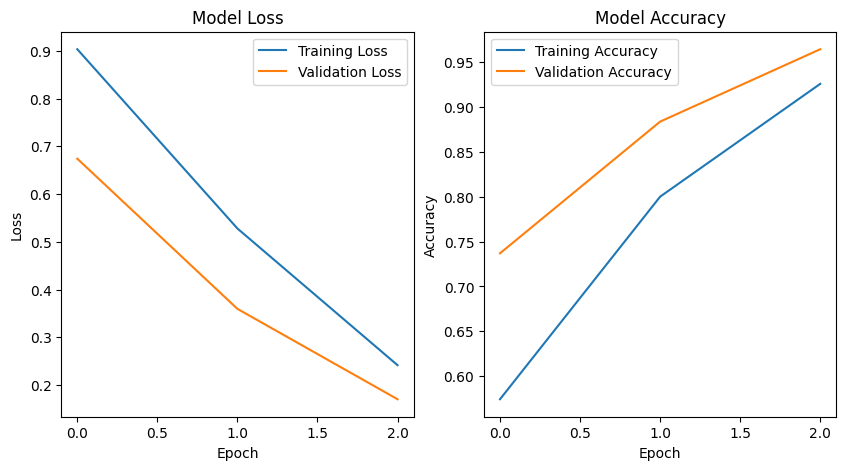

In [50]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()